In [1]:
#importing libraries
import numpy as np
import pandas as pd
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Load the data
data = pd.read_csv("MSFT.csv")

In [3]:
# Displaying information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entries, 0 to 9082
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9083 non-null   object 
 1   Open       9083 non-null   float64
 2   High       9083 non-null   float64
 3   Low        9083 non-null   float64
 4   Close      9083 non-null   float64
 5   Adj Close  9083 non-null   float64
 6   Volume     9083 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 496.9+ KB


In [4]:
#summary statitics
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9083.000000,9083.000000,9083.000000,9083.000000,9083.000000,9.083000e+03
mean,41.324936,41.760887,40.878488,41.335628,36.256120,5.875055e+07
std,59.696905,60.272218,59.081728,59.714567,59.981436,3.845200e+07
min,0.088542,0.092014,0.088542,0.090278,0.057046,2.304000e+06
25%,4.050781,4.102051,4.027344,4.075195,2.575089,3.461230e+07
50%,26.820000,27.100000,26.520000,26.840000,18.948530,5.203200e+07
75%,40.034999,40.443751,39.500000,39.937500,29.244812,7.265400e+07
max,344.619995,349.670013,342.200012,343.109985,342.402008,1.031789e+09


In [5]:
#displaying first 5 rows of the dataset
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


In [6]:
# Handling missing values
data.isnull().any(axis=1)
data = data.dropna()

In [7]:
# Preprocessing
#Normalizing data
data = data[['Date','Close']]
data = data.set_index('Date')
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [8]:
# Train-test split
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[:train_size, :], data[train_size:, :]

In [9]:
# Create dataset for time series prediction
def create_dataset(dataset, seq_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - seq_steps):
        a = dataset[i:(i + seq_steps), 0]
        X.append(a)
        Y.append(dataset[i + seq_steps, 0])
    return np.array(X), np.array(Y)
seq_steps = 10
X_train, y_train = create_dataset(train_data, seq_steps)
X_test, y_test = create_dataset(test_data, seq_steps)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [10]:
#build an LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=( 1,seq_steps)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Learning Curve Analysis
train_sizes = np.linspace(1, len(X_train), 10, dtype=int)
train_errors = []
test_errors = []

for train_size in train_sizes:
    X_subset, y_subset = X_train[:train_size], y_train[:train_size]
    print(f"Training on subset of size: {train_size}")

    # Train the model
    model.fit(X_subset, y_subset, epochs=5, batch_size=16, verbose=0)

    # Predict on the training and testing subsets
    train_pred = model.predict(X_subset)
    test_pred = model.predict(X_test[:train_size])

    # Calculate errors and handle NaN values
    train_mse = mean_squared_error(y_subset, train_pred)
    test_mse = mean_squared_error(y_test[:train_size], test_pred)

    if not np.isnan(train_mse) and not np.isnan(test_mse):
        train_errors.append(train_mse)
        test_errors.append(test_mse)
        print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

Training on subset of size: 1
1/1 [==============================] - 0s 24ms/step
Train MSE: 0.0000, Test MSE: 0.0189
Training on subset of size: 807
26/26 [==============================] - 0s 4ms/step
Train MSE: 0.0000, Test MSE: 0.0326
Training on subset of size: 1613
51/51 [==============================] - 0s 2ms/step
Train MSE: 0.0000, Test MSE: 0.0033
Training on subset of size: 2419
57/57 [==============================] - 0s 2ms/step
Train MSE: 0.0000, Test MSE: 0.0110
Training on subset of size: 3225
57/57 [==============================] - 0s 2ms/step
Train MSE: 0.0000, Test MSE: 0.0079
Training on subset of size: 4031
57/57 [==============================] - 0s 2ms/step
Train MSE: 0.0000, Test MSE: 0.0109
Training on subset of size: 4837
57/57 [==============================] - 0s 3ms/step
Train MSE: 0.0000, Test MSE: 0.0095
Training on subset of size: 5643
57/57 [==============================] - 0s 3ms/step
Train MSE: 0.0000, Test MSE: 0.0080
Training on subset of size: 6

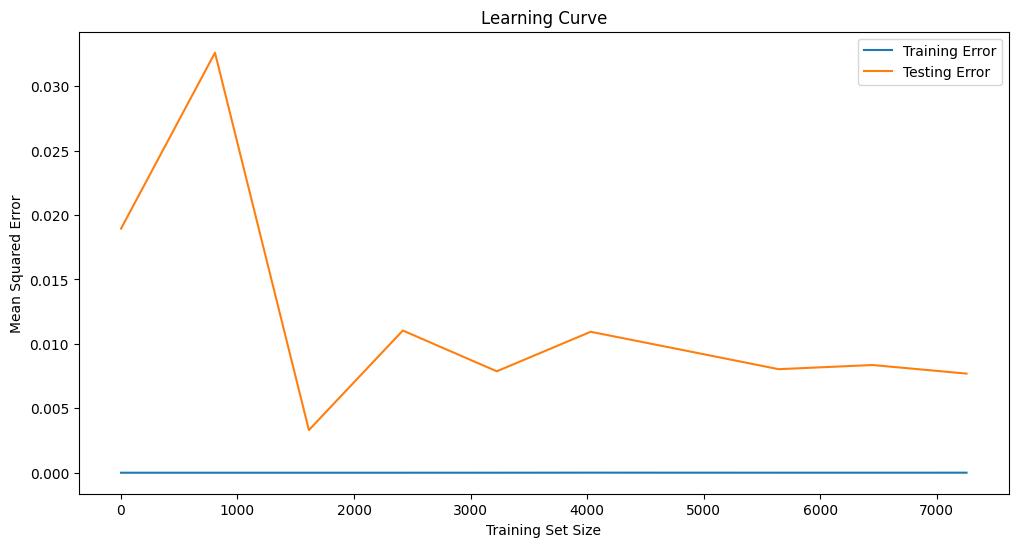

In [13]:
# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_errors, label='Training Error')
plt.plot(train_sizes, test_errors, label='Testing Error')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [14]:
# P-value Test
y_test_pred = model.predict(X_test)
p_values = f_regression(y_test_pred, y_test)[1]
print("P-values for predictions:", p_values)


57/57 [==============================] - 0s 3ms/step
P-values for predictions: [0.]


In [15]:
# Set a significance threshold
significance_threshold = 0.05

# Check p-values and make a decision
significant_predictions = np.where(p_values < significance_threshold)[0]
non_significant_predictions = np.where(p_values >= significance_threshold)[0]


for i in significant_predictions:
    print("\nSignificant predictions:")
    print(f"Sample {i+1}: p-value = {p_values[i]:.4f}, Prediction = {y_test_pred[i][0]:.4f}")


for i in non_significant_predictions:
    print("\nNon-significant predictions:")
    print(f"Sample {i+1}: p-value = {p_values[i]:.4f}, Prediction = {y_test_pred[i][0]:.4f}")


Significant predictions:
Sample 1: p-value = 0.0000, Prediction = 0.1328
